In [1]:
import os
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3, MobileNetV2, ResNet101

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, precision_score, recall_score, roc_auc_score, f1_score
from tensorflow.keras.metrics import Precision, Recall

In [2]:
def preprocess_data():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    return train_datagen, val_test_datagen

def load_datasets(train_datagen, val_test_datagen, batch_size=64, target_size=(120, 100)):
    train_dir = "Image_Datasets/splited_dataset/train" 
    val_dir = "Image_Datasets/splited_dataset/validation"
    test_dir = "Image_Datasets/splited_dataset/test"

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
    )

    validation_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb'
    )

    return train_generator, validation_generator, test_generator

train_datagen, val_test_datagen = preprocess_data()
train_generator, validation_generator, test_generator = load_datasets(train_datagen, val_test_datagen)


Found 8068 images belonging to 2 classes.
Found 1008 images belonging to 2 classes.
Found 1010 images belonging to 2 classes.


In [3]:
def spatial_attention_block(input_tensor):
    avg_pool = layers.GlobalAveragePooling2D()(input_tensor)
    max_pool = layers.GlobalMaxPooling2D()(input_tensor)
    
    avg_pool = layers.Reshape((1, 1, input_tensor.shape[-1]))(avg_pool)
    max_pool = layers.Reshape((1, 1, input_tensor.shape[-1]))(max_pool)
    
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    output_tensor = layers.Multiply()([input_tensor, attention])
    return output_tensor

In [4]:
def depthwise_separable_resnet_model(input_tensor, filters, kernel_size=3, stride=1,conv_shortcut=False):
    
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)


    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.DepthwiseConv2D(kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    if conv_shortcut or stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same")(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x

def squeeze_excitation_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu', kernel_regularizer=l2(0.01), use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_regularizer=l2(0.01), use_bias=False)(se)

    x = layers.multiply([input_tensor, se])
    return x


def inception_with_SE_model(input_tensor, filters, l2_rate):

    conv1x1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)

    conv3x3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)

    conv5x5_1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)
    conv5x5_2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(conv5x5_1)
    conv5x5_3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(conv5x5_2)

    pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    pool_conv = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(pool)

    outputs = layers.concatenate([conv1x1, conv3x3, conv5x5_3, pool_conv], axis=-1)
    output_with_se = squeeze_excitation_block(outputs)
    return output_with_se



def Franklin_combined_model_1(input_shape, num_classes, l2_rate):
    inputs = layers.Input(shape=input_shape)

    x = depthwise_separable_resnet_model(inputs, filters=64)
    x = depthwise_separable_resnet_model(x, filters=32)
    x = spatial_attention_block(x)

    x = layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = inception_with_SE_model(x, 32, l2_rate)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x) 
      
    x = inception_with_SE_model(x, 32, l2_rate) 
    x = spatial_attention_block(x) 
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    combined_model_with_attention = models.Model(inputs=inputs, outputs=outputs)
    return combined_model_with_attention

In [5]:
def resnet_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=False):
  
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    if conv_shortcut or stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same")(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def inception_model(input_tensor, filters, l2_rate):

    conv1x1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)

    conv3x3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(conv1x1)

    conv5x5 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)
    conv5x5 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(conv5x5)
    conv5x5 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(conv5x5)

    pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    pool_conv = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(pool)

    output = layers.concatenate([conv1x1, conv3x3, conv5x5, pool_conv], axis=-1)
    return output

def Franklin_combined_model_2(input_shape, num_classes, l2_rate):
    inputs = layers.Input(shape=input_shape)

    x = resnet_block(inputs, filters=64)
    x = resnet_block(x, filters=64)
    x = spatial_attention_block(x)  

    x = layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = inception_model(x, 32, l2_rate)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = inception_model(x, 32, l2_rate)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    combined_model_with_attention = models.Model(inputs=inputs, outputs=outputs)
    return combined_model_with_attention

In [6]:
def build_resnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    base_model = ResNet101(weights='imagenet', include_top=False, input_tensor=inputs)
    base_model.trainable = False

    # base_model = ResNet101(weights=None, include_top=False, input_tensor=inputs)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',  
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    return model


In [7]:
def build_inception_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)
    base_model.trainable = False
    # base_model = InceptionV3(weights=None, include_top=False, input_tensor=inputs)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)  
    Dense(1024, activation='relu'), 

    predictions = Dense(num_classes, activation='softmax')(x)  

    model = Model(inputs=inputs, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',  
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]) 

    return model

In [8]:
def build_mobilenet_model(input_shape, num_classes):

    inputs = Input(shape=input_shape)

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)
    base_model.trainable = False
    # base_model = MobileNetV2(weights=None, include_top=False, input_tensor=inputs)

    x = base_model.output
    x = GlobalAveragePooling2D()(x) 
    Dense(1024, activation='relu'),  

    predictions = Dense(num_classes, activation='softmax')(x)  


    model = Model(inputs=inputs, outputs=predictions)


    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',  
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])  

    return model

In [9]:

input_shape = (120, 100, 3) 
num_classes = 2
epochs = 50


pretrain_resnet_model = build_resnet_model(input_shape, num_classes)
pretrain_inception_model = build_inception_model(input_shape, num_classes)
pretrain_mobilenet_model = build_mobilenet_model(input_shape, num_classes)

Franklin_combined_model_1 = Franklin_combined_model_1(input_shape, num_classes, l2_rate=0.001)
Franklin_combined_model_2 = Franklin_combined_model_2(input_shape, num_classes, l2_rate=0.01)



In [10]:

Franklin_combined_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
Franklin_combined_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')



In [12]:
history_resnet = pretrain_resnet_model.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=[early_stopping, lr_reduction])
pretrain_resnet_model.save('compare_model_with_pre_train_model/model_comparison/resnet_model.h5')

Epoch 1/50
127/127 [==============================] - 16s 103ms/step - loss: 0.7654 - accuracy: 0.5087 - precision: 0.5087 - recall: 0.5087 - val_loss: 0.6793 - val_accuracy: 0.5496 - val_precision: 0.5496 - val_recall: 0.5496 - lr: 0.0010
Epoch 2/50
127/127 [==============================] - 12s 98ms/step - loss: 0.6873 - accuracy: 0.5408 - precision: 0.5408 - recall: 0.5408 - val_loss: 0.6637 - val_accuracy: 0.6349 - val_precision: 0.6349 - val_recall: 0.6349 - lr: 0.0010
Epoch 3/50
127/127 [==============================] - 12s 98ms/step - loss: 0.6875 - accuracy: 0.5570 - precision: 0.5570 - recall: 0.5570 - val_loss: 0.6680 - val_accuracy: 0.5516 - val_precision: 0.5516 - val_recall: 0.5516 - lr: 0.0010
Epoch 4/50
127/127 [==============================] - 12s 98ms/step - loss: 0.6817 - accuracy: 0.5641 - precision: 0.5641 - recall: 0.5641 - val_loss: 0.7192 - val_accuracy: 0.5030 - val_precision: 0.5030 - val_recall: 0.5030 - lr: 0.0010
Epoch 5/50
127/127 [=======================

In [13]:
history_inception = pretrain_inception_model.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=[early_stopping, lr_reduction])
pretrain_inception_model.save('compare_model_with_pre_train_model/model_comparison/inception_model.h5')

Epoch 1/50
127/127 [==============================] - 15s 102ms/step - loss: 0.4866 - accuracy: 0.7771 - precision: 0.7771 - recall: 0.7771 - val_loss: 0.3133 - val_accuracy: 0.8790 - val_precision: 0.8790 - val_recall: 0.8790 - lr: 0.0010
Epoch 2/50
127/127 [==============================] - 12s 97ms/step - loss: 0.3883 - accuracy: 0.8304 - precision: 0.8304 - recall: 0.8304 - val_loss: 0.2937 - val_accuracy: 0.8790 - val_precision: 0.8790 - val_recall: 0.8790 - lr: 0.0010
Epoch 3/50
127/127 [==============================] - 12s 97ms/step - loss: 0.3825 - accuracy: 0.8345 - precision: 0.8345 - recall: 0.8345 - val_loss: 0.2860 - val_accuracy: 0.8859 - val_precision: 0.8859 - val_recall: 0.8859 - lr: 0.0010
Epoch 4/50
127/127 [==============================] - 12s 97ms/step - loss: 0.3720 - accuracy: 0.8385 - precision: 0.8385 - recall: 0.8385 - val_loss: 0.2949 - val_accuracy: 0.8730 - val_precision: 0.8730 - val_recall: 0.8730 - lr: 0.0010
Epoch 5/50
127/127 [=======================

In [14]:
history_mobilenet = pretrain_mobilenet_model.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=[early_stopping, lr_reduction])
pretrain_mobilenet_model.save('compare_model_with_pre_train_model/model_comparison/mobilenet_model.h5')

Epoch 1/50
127/127 [==============================] - 14s 101ms/step - loss: 0.5234 - accuracy: 0.7594 - precision: 0.7594 - recall: 0.7594 - val_loss: 0.3347 - val_accuracy: 0.8462 - val_precision: 0.8462 - val_recall: 0.8462 - lr: 0.0010
Epoch 2/50
127/127 [==============================] - 12s 97ms/step - loss: 0.3661 - accuracy: 0.8412 - precision: 0.8412 - recall: 0.8412 - val_loss: 0.2961 - val_accuracy: 0.8681 - val_precision: 0.8681 - val_recall: 0.8681 - lr: 0.0010
Epoch 3/50
127/127 [==============================] - 12s 97ms/step - loss: 0.3376 - accuracy: 0.8577 - precision: 0.8577 - recall: 0.8577 - val_loss: 0.2935 - val_accuracy: 0.8710 - val_precision: 0.8710 - val_recall: 0.8710 - lr: 0.0010
Epoch 4/50
127/127 [==============================] - 12s 97ms/step - loss: 0.3135 - accuracy: 0.8659 - precision: 0.8659 - recall: 0.8659 - val_loss: 0.2842 - val_accuracy: 0.8681 - val_precision: 0.8681 - val_recall: 0.8681 - lr: 0.0010
Epoch 5/50
127/127 [=======================

In [15]:
history_Franklinnet_1 = Franklin_combined_model_1.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=[early_stopping, lr_reduction])
Franklin_combined_model_1.save('compare_model_with_pre_train_model/model_comparison/franklin_combined_model_1.h5')

Epoch 1/50
127/127 [==============================] - 14s 99ms/step - loss: 1.0781 - accuracy: 0.6525 - precision: 0.6525 - recall: 0.6525 - val_loss: 1.0268 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - lr: 0.0010
Epoch 2/50
127/127 [==============================] - 12s 97ms/step - loss: 0.4916 - accuracy: 0.8162 - precision: 0.8162 - recall: 0.8162 - val_loss: 0.8914 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - lr: 0.0010
Epoch 3/50
127/127 [==============================] - 12s 97ms/step - loss: 0.3775 - accuracy: 0.8546 - precision: 0.8546 - recall: 0.8546 - val_loss: 0.9990 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - lr: 0.0010
Epoch 4/50
127/127 [==============================] - 12s 97ms/step - loss: 0.3300 - accuracy: 0.8686 - precision: 0.8686 - recall: 0.8686 - val_loss: 1.0775 - val_accuracy: 0.5179 - val_precision: 0.5179 - val_recall: 0.5179 - lr: 0.0010
Epoch 5/50
127/127 [========================

In [16]:
history_Franklinnet_2 = Franklin_combined_model_2.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=[early_stopping, lr_reduction])
Franklin_combined_model_2.save('compare_model_with_pre_train_model/model_comparison/franklin_combined_model_2.h5')

Epoch 1/50
127/127 [==============================] - 14s 99ms/step - loss: 2.4182 - accuracy: 0.5058 - precision: 0.5058 - recall: 0.5058 - val_loss: 1.3028 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - lr: 0.0010
Epoch 2/50
127/127 [==============================] - 12s 97ms/step - loss: 0.8253 - accuracy: 0.6694 - precision: 0.6694 - recall: 0.6694 - val_loss: 1.8357 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - lr: 0.0010
Epoch 3/50
127/127 [==============================] - 12s 97ms/step - loss: 0.5110 - accuracy: 0.7863 - precision: 0.7863 - recall: 0.7863 - val_loss: 1.1644 - val_accuracy: 0.5040 - val_precision: 0.5040 - val_recall: 0.5040 - lr: 0.0010
Epoch 4/50
127/127 [==============================] - 12s 97ms/step - loss: 0.4159 - accuracy: 0.8322 - precision: 0.8322 - recall: 0.8322 - val_loss: 0.5246 - val_accuracy: 0.7302 - val_precision: 0.7302 - val_recall: 0.7302 - lr: 0.0010
Epoch 5/50
127/127 [========================

In [ ]:
def plot_all_models_history(histories, labels, metric):
    plt.figure(figsize=(12, 8))

    for history, label in zip(histories, labels):
        epochs = range(1, len(history.history[metric]) + 1)
        plt.plot(epochs, history.history[metric], label=f'{label} Training')
        plt.plot(epochs, history.history[f'val_{metric}'], '--', label=f'{label} Validation')

    plt.title(f'Training and Validation {metric.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()

    plt.show()


def load_and_predict_model(model_path, test_generator, custom_objects):
    loaded_model = load_model(model_path, custom_objects=custom_objects)
    all_images = []
    all_true_labels = []

    for _ in range(test_generator.samples // test_generator.batch_size):
        images, true_labels = next(test_generator)
        all_images.extend(images)
        all_true_labels.extend(true_labels)

    all_images = np.array(all_images)
    all_true_labels = np.argmax(np.array(all_true_labels), axis=1)

    predictions = loaded_model.predict(all_images)
    predicted_labels = np.argmax(predictions, axis=1)

    return all_true_labels, predicted_labels, predictions

def calculate_f1_scores(true_labels, predicted_probabilities):
    thresholds = np.linspace(0, 1, 100)
    f1_scores = []

    for thresh in thresholds:
        predicted_labels_thresh = (predicted_probabilities[:, 1] >= thresh).astype(int)

        precision = precision_score(true_labels, predicted_labels_thresh, zero_division=0)
        recall = recall_score(true_labels, predicted_labels_thresh)

        if precision + recall == 0:
            f1_scores.append(0)
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
            f1_scores.append(f1)

    return thresholds, f1_scores

def calculate_sensitivity_specificity(true_labels, predicted_probabilities):
    thresholds = np.linspace(0, 1, 100)
    sensitivity_scores = []
    specificity_scores = []

    for thresh in thresholds:
        predicted_labels_thresh = (predicted_probabilities[:, 1] >= thresh).astype(int)

        tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels_thresh).ravel()

        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

        sensitivity_scores.append(sensitivity)
        specificity_scores.append(specificity)

    return thresholds, sensitivity_scores, specificity_scores


def plot_confusion_matrix(true_labels, predicted_labels):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

def plot_all_roc_auc_curves(model_results):
    plt.figure(figsize=(12, 8))

    for true_labels, predicted_probabilities, label in model_results:
        fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities[:, 1]) 
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve Comparison')
    plt.legend(loc="lower right")
    plt.show()

def plot_all_precision_recall_curves(model_results):
    plt.figure(figsize=(12, 8))

    for true_labels, predicted_probabilities, label in model_results:
        precision, recall, _ = precision_recall_curve(true_labels, predicted_probabilities[:, 1])
        plt.plot(recall, precision, marker='.', label=label)

    plt.title('Precision-Recall Curve Comparison')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()


def plot_all_f1_scores(model_results):
    plt.figure(figsize=(12, 8))

    for true_labels, predicted_probabilities, label in model_results:
        thresholds, f1_scores = calculate_f1_scores(true_labels, predicted_probabilities)
        plt.plot(thresholds, f1_scores, marker='.', label=label)

    plt.title('F1-Score Comparison')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()


def plot_sensitivity(model_results):
    plt.figure(figsize=(12, 8))
    for true_labels, predicted_probabilities, label in model_results:
        thresholds, sensitivity_scores, _ = calculate_sensitivity_specificity(true_labels, predicted_probabilities)
        plt.plot(thresholds, sensitivity_scores, marker='.', label=label)
    plt.title('Sensitivity Comparison')
    plt.xlabel('Threshold')
    plt.ylabel('Sensitivity')
    plt.legend()
    plt.show()


def plot_specificity(model_results):
    plt.figure(figsize=(12, 8))
    for true_labels, predicted_probabilities, label in model_results:
        thresholds, _, specificity_scores = calculate_sensitivity_specificity(true_labels, predicted_probabilities)
        plt.plot(thresholds, specificity_scores, marker='.', label=label)
    plt.title('Specificity Comparison')
    plt.xlabel('Threshold')
    plt.ylabel('Specificity')
    plt.legend()
    plt.show()

def plot_confusion_matrix(true_labels, predicted_labels, ax, title):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"], ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

def plot_all_confusion_matrices(model_results):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    axes = axes.flatten()

    for i, (true_labels, predicted_probabilities, model_name) in enumerate(model_results):
   
        if predicted_probabilities.ndim == 1:
            predicted_probabilities = np.expand_dims(predicted_probabilities, axis=-1)


        predicted_labels = np.argmax(predicted_probabilities, axis=1)

    
        if true_labels.ndim == 2:
            true_labels = np.argmax(true_labels, axis=1)

        plot_confusion_matrix(true_labels, predicted_labels, axes[i], model_name)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def print_classification_metrics(true_labels, predicted_labels, predicted_probabilities, model_name, model_path, test_generator):
    model = load_model(model_path)
    test_generator.reset()  
    cm = confusion_matrix(true_labels, predicted_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    auc = roc_auc_score(true_labels, predicted_probabilities[:, 1]) if predicted_probabilities is not None else "N/A"
    loss, accuracy = model.evaluate(test_generator)
    print(f"Model: {model_name}")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC: {auc}")
    print("Confusion Matrix:")
    print(cm)
    print('---------------------------------')


def plot_history(histories, key='loss'):
    plt.figure(figsize=(15, 5))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()

    plt.xlim([0, max(history.epoch)])


all_histories_1 = [
    ('resnet', history_resnet),
    ('inception', history_inception),
    ('mobilenet', history_mobilenet),
    ('franklinnet_1', history_Franklinnet_1),
    ('franklinnet_2', history_Franklinnet_2)
]


all_histories = [history_resnet, history_inception, history_mobilenet, history_Franklinnet_1, history_Franklinnet_2]
labels = ['ResNet', 'Inception', 'MobileNet', 'FranklinNet 1', 'FranklinNet 2']


In [4]:
model_paths = [
    'compare_model_with_pre_train_model/model_comparison/resnet_model.h5',
    'compare_model_with_pre_train_model/model_comparison/inception_model.h5',
    'compare_model_with_pre_train_model/model_comparison/mobilenet_model.h5',
    'compare_model_with_pre_train_model/model_comparison/franklin_combined_model_1.h5',
    'compare_model_with_pre_train_model/model_comparison/franklin_combined_model_2.h5'
]
model_names = ['ResNet', 'Inception', 'MobileNet', 'FranklinNet 1', 'FranklinNet 2']

model_results = []
for model_path, model_name in zip(model_paths, model_names):
    true_labels, _, predicted_probabilities = load_and_predict_model(model_path, test_generator, custom_objects=None)
    model_results.append((true_labels, predicted_probabilities, model_name))

30/30 [==============================] - 0s 12ms/step


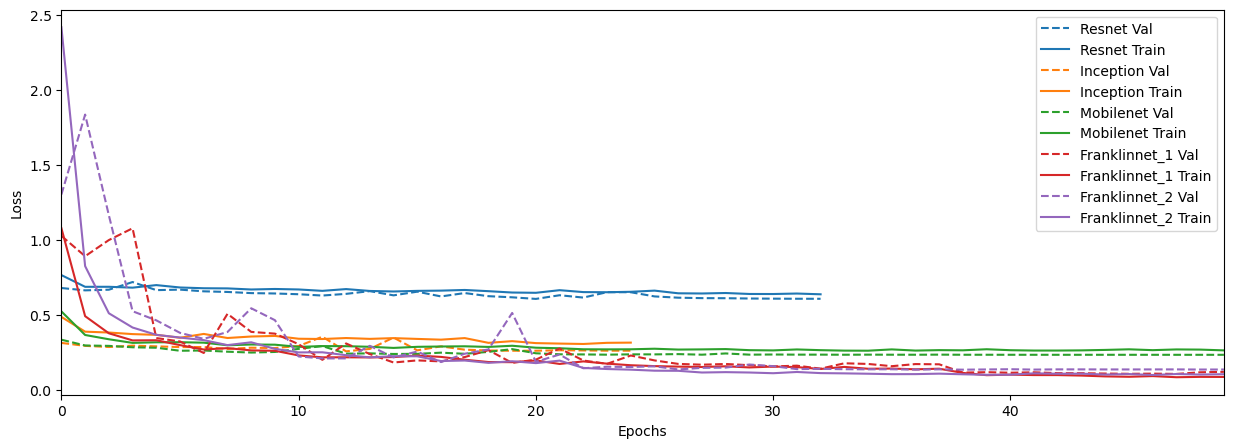

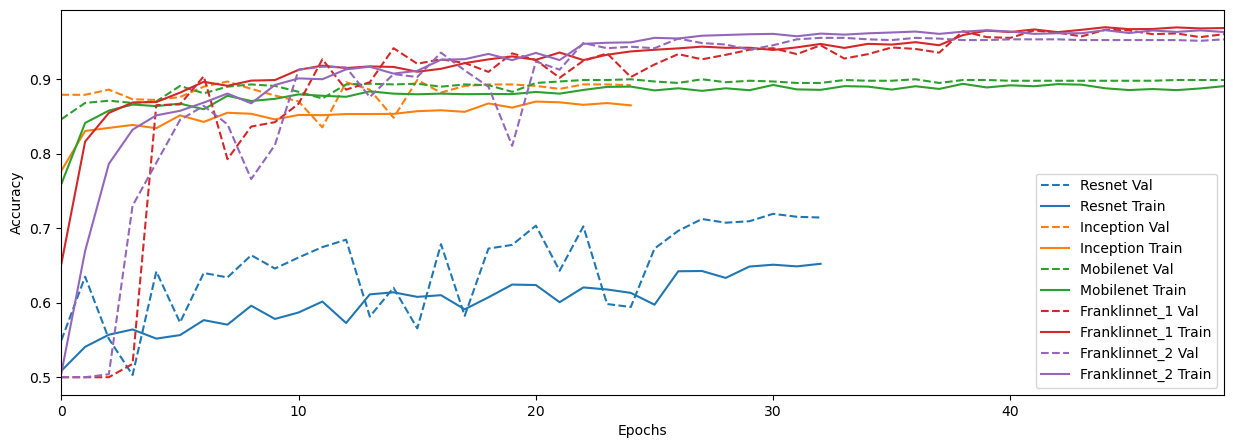

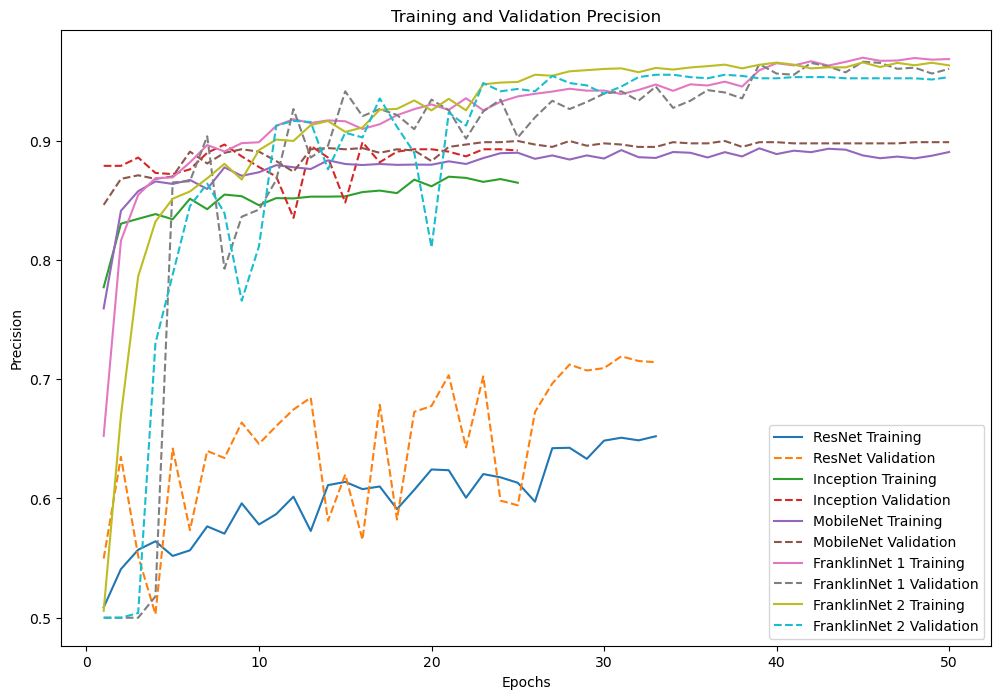

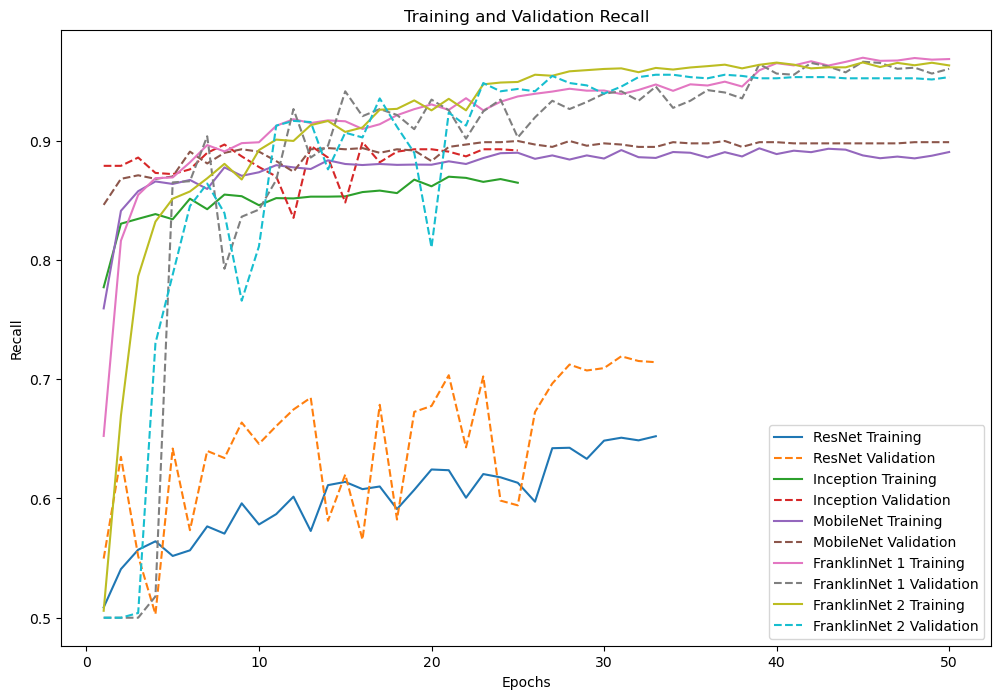

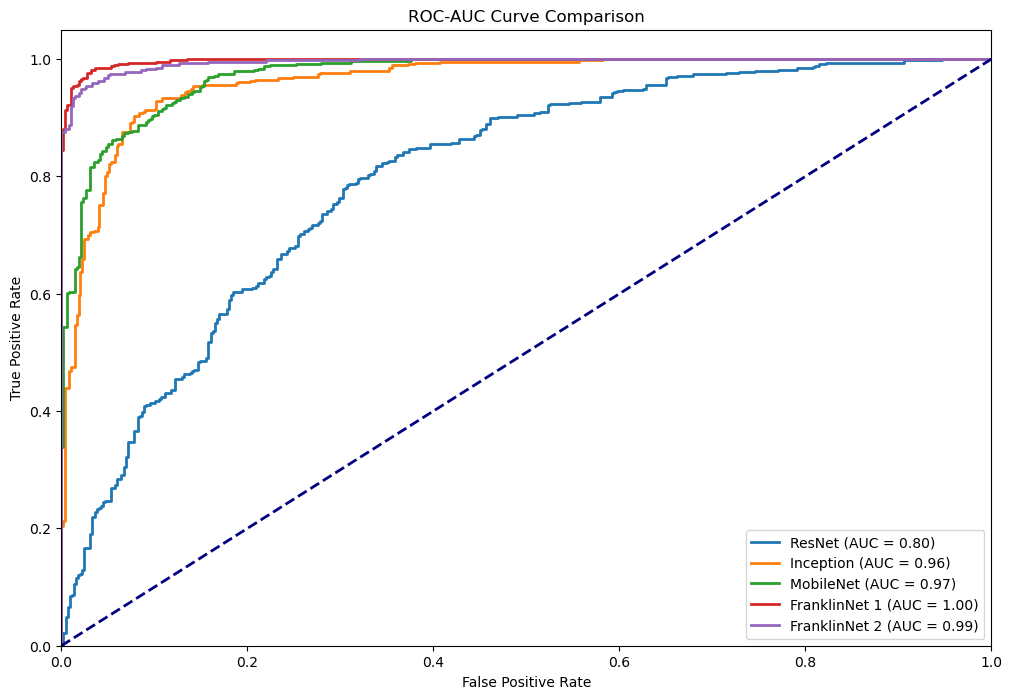

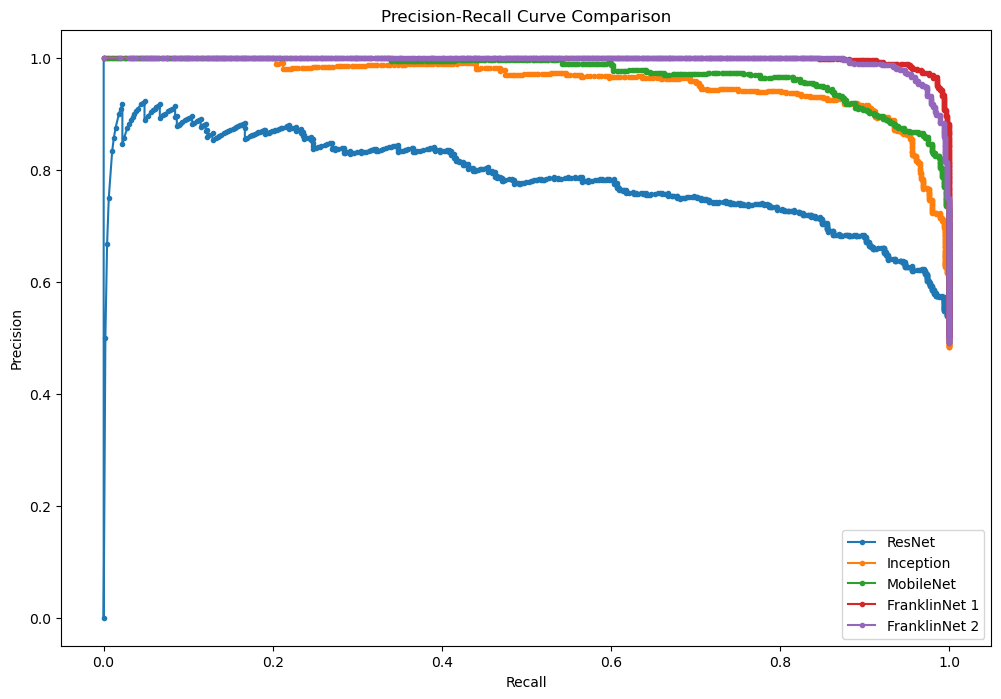

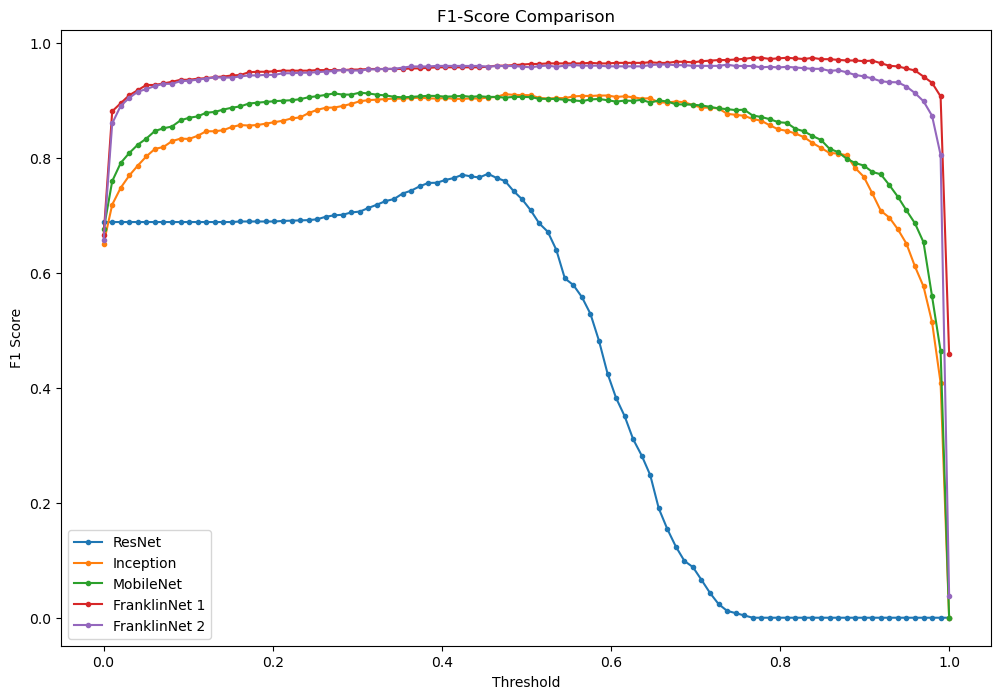

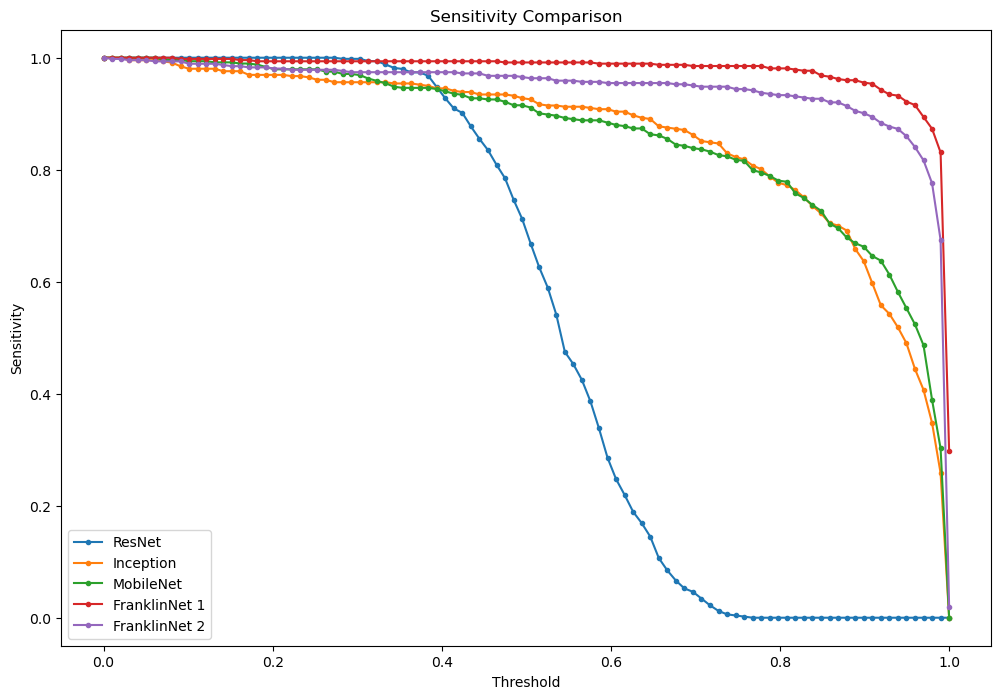

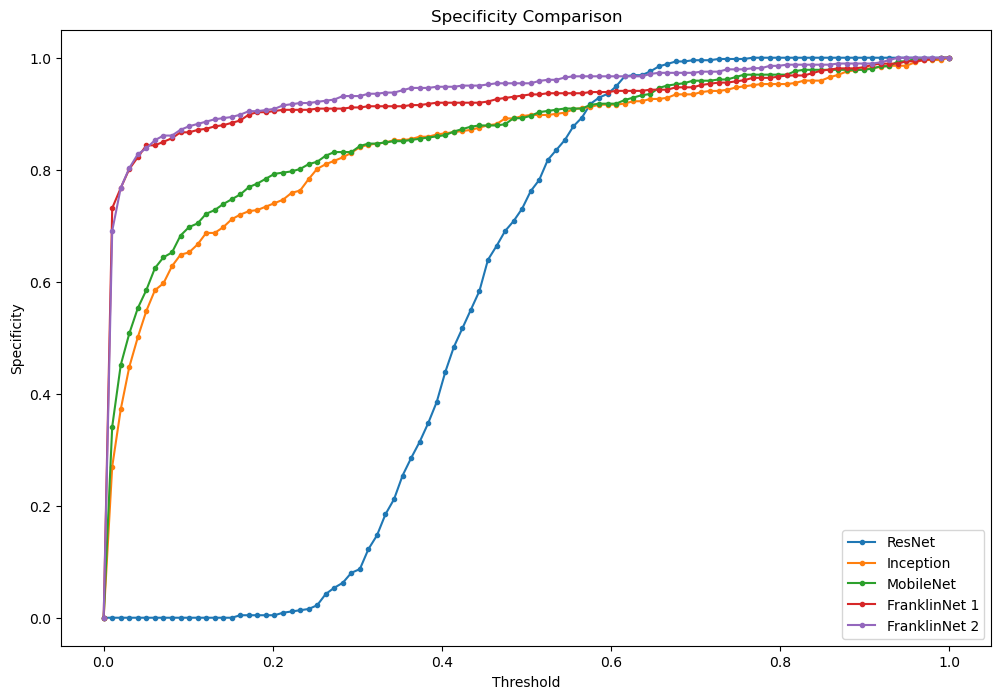

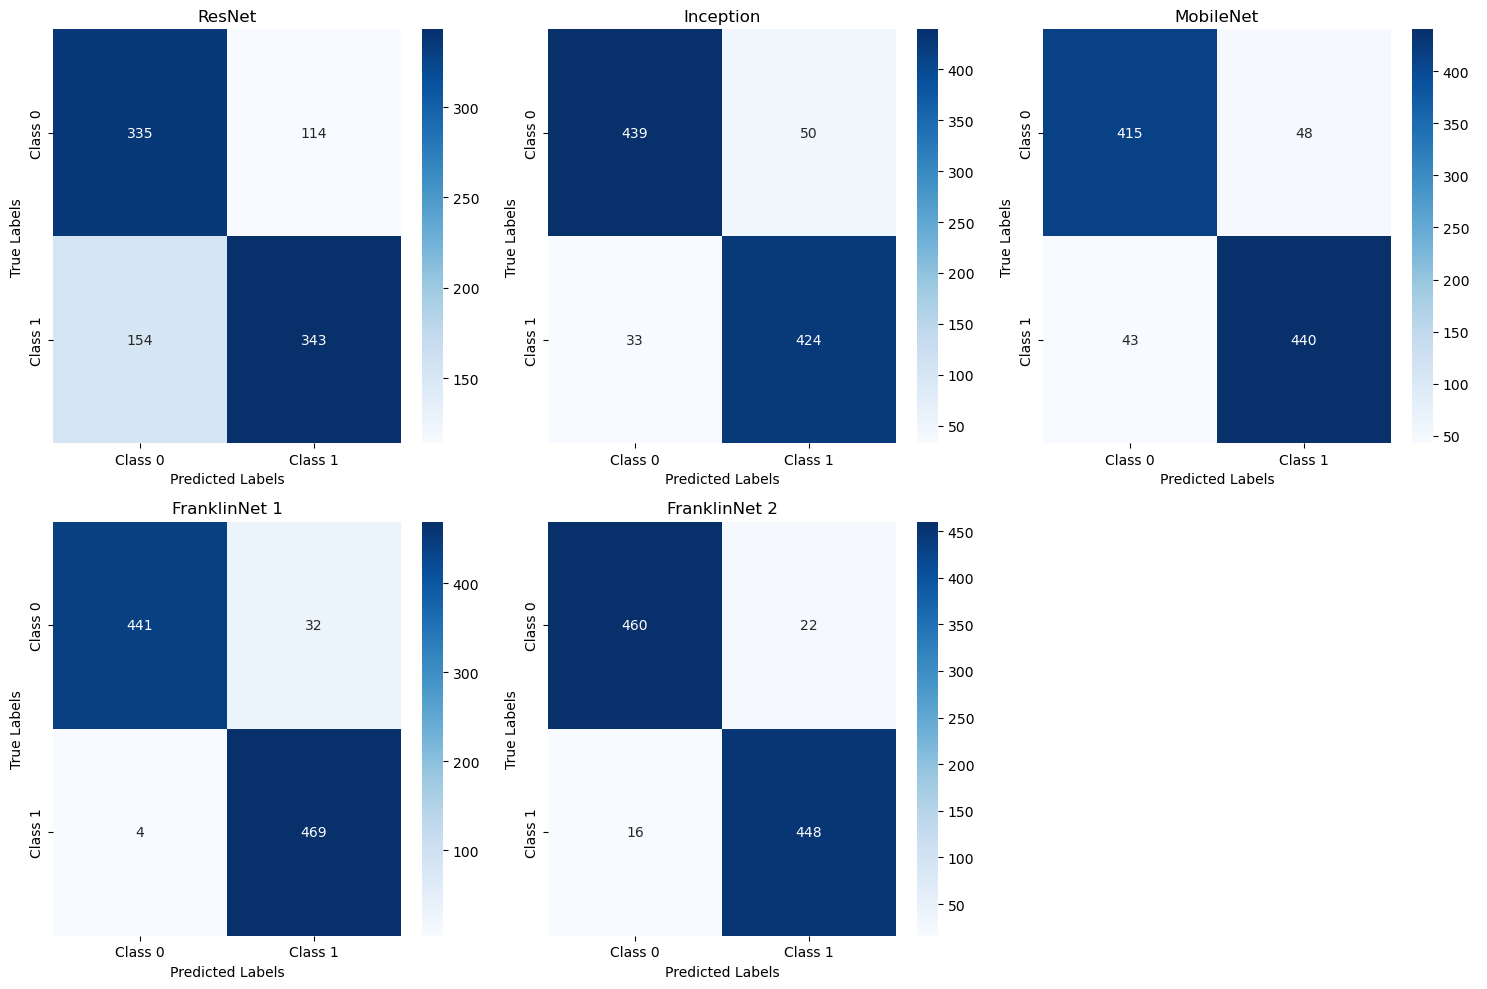

In [26]:
plot_history(all_histories_1, key='loss')
plot_history(all_histories_1, key='accuracy')

for metric in [ 'precision', 'recall']:
    plot_all_models_history(all_histories, labels, metric)

plot_all_roc_auc_curves(model_results)
plot_all_precision_recall_curves(model_results)
plot_all_f1_scores(model_results)
plot_sensitivity(model_results)
plot_specificity(model_results)
plot_all_confusion_matrices(model_results)


In [ ]:
# for model_path, model_name in zip(model_paths, model_names):
#     true_labels, predicted_labels, predicted_probabilities = load_and_predict_model(model_path, test_generator,custom_objects=None)
#     thresholds, f1_scores = calculate_f1_scores(true_labels, predicted_probabilities)
#     thresholds, sensitivity_scores, specificity_scores = calculate_sensitivity_specificity(true_labels, predicted_probabilities)
#     print_classification_metrics(true_labels, predicted_labels, predicted_probabilities, model_name=model_name, model_path=model_path, test_generator=test_generator)
    
